# Species comparison: heterogeneity

**Purpose**: To compare the heterogeneity of cleavage across yeast species and humans.


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

## IMPORTS AND SETUP

In [4]:
from paper_utilities import cleavage

In [5]:
PROJECT   = "/projects/b1080/eks/polyadenylation/yeast"
DATADIR   = os.path.join(PROJECT, 'external_data', 'conservation')
OUTDIR    = os.path.join(PROJECT, 'manuscript', 'analysis', 'species_comparison')
RESOURCES = os.path.join(os.path.dirname(OUTDIR), 'resources')
os.makedirs(OUTDIR, exist_ok = True)


In [6]:
with open(os.path.join(RESOURCES, 'homologous_genes.map.pickle'), mode = 'rb') as handle:
    homologs_map = pickle.load(handle)
    

In [7]:
with open(os.path.join(RESOURCES, 'conservation.cds_scores.pickle'), mode = 'rb') as handle:
    cds_scores = pickle.load(handle)


In [8]:
with open(os.path.join(RESOURCES, 'conservation.top1_sites.pickle'), mode = 'rb') as handle:
    top1_data = pickle.load(handle)

with open(os.path.join(RESOURCES, 'conservation.gold_sites.pickle'), mode = 'rb') as handle:
    gold_data = pickle.load(handle)

print("Top1 site conservation data:", top1_data.shape)
print("Gold site conservation data:", gold_data.shape)


Top1 site conservation data: (25603, 20)
Gold site conservation data: (24116, 20)


## HELPER FUNCTIONS

In [31]:
def find_entropy_examples(data, cons_dict, feature = None, gene = None, rs = None, margin = 0, verbose = True):
    
    if (feature is None):
        cons_data = data.loc[(data['conserved_yeast_to_human'] == True)]
    else:
        
        hsap_feature = 'terminal_exon' if (feature == 'utr3') else feature
        condYEAST = (data['species'].isin(['S.cerevisiae','S.pombe']) & (data['feature'] == feature))
        condHUMAN = (data['species'] == 'H.sapiens') & (data['feature'] == hsap_feature)
        cons_data = data.loc[(data['conserved_yeast_to_human'] == True) & (condYEAST | condHUMAN)]
    
    ## Find high entropy site in cerevisiae
    
    if (gene is not None):        
        high_cerev = cons_data.loc[(cons_data['species'] == 'S.cerevisiae') & (cons_data['observed_entropy_bin'] == 'H') & (cons_data['gene'] == gene)].sample(n = 1, random_state = rs).iloc[0]
    else:
        if (rs is None):
            rs = np.random.randint(0, 2**32 - 1)
        high_cerev = cons_data.loc[(cons_data['species'] == 'S.cerevisiae') & (cons_data['observed_entropy_bin'] == 'H')].sample(n = 1, random_state = rs).iloc[0]
    
    ## Find middle entropy site in pombe
    
    matching_pombe_genes = cons_dict.get(f'scer_{high_cerev.featureName}',{}).get('spom','NA')
    middle_pombe = cons_data.loc[(cons_data['species'] == 'S.pombe') & (cons_data['observed_entropy'] < (high_cerev['observed_entropy']-margin))].sample(n = 1, random_state = rs).iloc[0]
    
    ## Find low entropy site in human
    
    matching_human_genes = cons_dict.get(f'scer_{high_cerev.featureName}',{}).get('hsap','NA')
    low_human = cons_data.loc[(cons_data['species'] == 'H.sapiens') & (cons_data['observed_entropy'] < (middle_pombe['observed_entropy']-margin))].sample(n = 1, random_state = rs).iloc[0]
    
    if (verbose):
        
        print("Sampling using random state", rs)
        print("S.cerevisiae:\t", "\t".join([str(x) for x in [high_cerev['siteKey'], high_cerev['gene'], high_cerev['feature'], high_cerev['supporting_reads'], high_cerev['observed_entropy']]]))
        print("S.pombe     :\t", "\t".join([str(x) for x in [middle_pombe['siteKey'], middle_pombe['gene'], middle_pombe['feature'], middle_pombe['supporting_reads'], middle_pombe['observed_entropy']]]))
        print("H.sapiens   :\t", "\t".join([str(x) for x in [low_human['siteKey'], low_human['gene'], low_human['feature'], low_human['supporting_reads'], low_human['observed_entropy']]]))
    
    return gene, rs, high_cerev, middle_pombe, low_human


In [32]:
def plot_entropy_examples(example_gene, example_rs, example_cerev, example_pombe, example_human, window = 50):
    
    fig,ax = plt.subplots(6,1, figsize = (3,2), sharex = True, gridspec_kw = {'height_ratios' : [3,1,3,1,3,1]})
    
    seq_lbound = int((len(example_cerev['sequence']) - window)/2)
    seq_ubound = int((len(example_cerev['sequence']) + window)/2)
    
    vec_lbound = int((len(example_cerev['readvec']) - window)/2)
    vec_ubound = int((len(example_cerev['readvec']) + window)/2)
    
    xs = np.arange(-(window/2), +(window/2), 1)
    
    ## S.cerevisiae
    
    ax[0].bar(xs, example_cerev['readvec'][vec_lbound:vec_ubound], width = 1, color = 'gray')
    
    subseq = example_cerev['sequence'][seq_lbound:seq_ubound]
    subenc = cleavage.encode_sequence(subseq)
    submot = pd.DataFrame(subenc, columns = ['A','C','G','U'], index = xs)
    
    logo = logomaker.Logo(submot, ax = ax[1], width = 0.8, vpad = 0.05)
    
    ## S.pombe
    
    ax[2].bar(xs, example_pombe['readvec'][vec_lbound:vec_ubound], width = 1, color = 'gray')
    
    subseq = example_pombe['sequence'][seq_lbound:seq_ubound]
    subenc = cleavage.encode_sequence(subseq)
    submot = pd.DataFrame(subenc, columns = ['A','C','G','U'], index = xs)
    
    logo = logomaker.Logo(submot, ax = ax[3], width = 0.8, vpad = 0.05)
    
    ## H.sapiens
    
    ax[4].bar(xs, example_human['readvec'][vec_lbound:vec_ubound], width = 1, color = 'gray')
    
    subseq = example_human['sequence'][seq_lbound:seq_ubound]
    subenc = cleavage.encode_sequence(subseq)
    submot = pd.DataFrame(subenc, columns = ['A','C','G','U'], index = xs)
    
    logo = logomaker.Logo(submot, ax = ax[5], width = 0.8, vpad = 0.05)
    
    ## style plot
    
    for a in ax:
        a.set_xticks(np.arange(-int(window/2),int(window/2)+1,5))
        a.set_yticks([])
    
        a.spines['left'].set_visible(False)
        a.spines['right'].set_visible(False)
        a.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join(OUTDIR, f'species_entropy_comparison.{example_gene}.{example_rs}.svg'), format = 'svg', dpi = 600, transparent = True)
    plt.show()
    
    return


# ANALYSIS

## Heterogeneity analysis

In [11]:
species_order = ['S.cerevisiae','S.pombe','H.sapiens']

species_palette = {
    'S.cerevisiae' : sns.color_palette("Set2")[0],
    'S.pombe'      : sns.color_palette("Set2")[1],
    'H.sapiens'    : sns.color_palette("Set2")[2],
}

### Examples of cleavage profile around top sites across species

Sampling using random state 575485529
S.cerevisiae:	 XIII:507360:-	YMR120C	utr3	2079.666666666667	3.037304904007171
S.pombe     :	 II:557847:-	SPBC354.07c	utr3	43.5	1.8786853890911932
H.sapiens   :	 10:68482703:-	ENSG00000122912.15	terminal_exon	457.99999999999983	1.3786241299304556


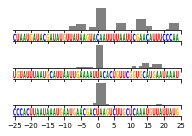

In [12]:
## Find new examples by running function with no random state given
example_rs, example_cerev, example_pombe, example_human = find_entropy_examples(top1_data, homologs_map, "utr3", margin=0.2)
plot_entropy_examples(example_rs, example_cerev, example_pombe, example_human)

# 575485529

Sampling using random state 1234
S.cerevisiae:	 XIII:533090:-	YMR131C	utr3	1195.5	2.9083025698944676
S.pombe     :	 II:3725111:+	SPBC25D12.05	utr3	16.0	2.1990416146641123
H.sapiens   :	 7:99457370:+	ENSG00000160917.15	terminal_exon	1891.333333333333	1.5495463296724024


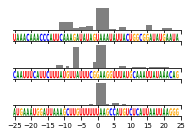

In [34]:
example_outputs = find_entropy_examples(top1_data, homologs_map, "utr3", gene = "YMR131C", rs = 1234)
plot_entropy_examples(*example_outputs)


Sampling using random state 12345
S.cerevisiae:	 XI:382594:-	YKL029C	utr3	22.33333333333333	3.1826164979358347
S.pombe     :	 I:4463032:-	SPAC9E9.12c	utr3	17.75	2.0712754416861325
H.sapiens   :	 1:9271332:+	ENSG00000049239.13	terminal_exon	1104.4	1.6830847309609311


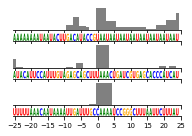

In [36]:
example_outputs = find_entropy_examples(top1_data, homologs_map, "utr3", gene = "YKL029C", rs = 12345)
plot_entropy_examples(*example_outputs)


Sampling using random state 12345
S.cerevisiae:	 XIV:167082:-	YNL255C	utr3	577.5	2.924320742963858
S.pombe     :	 I:2059145:-	SPAC732.02c	utr3	9.333333333333334	2.4173065649862724
H.sapiens   :	 5:178149466:-	ENSG00000145912.10	terminal_exon	37327.59999999997	1.7896010211652342


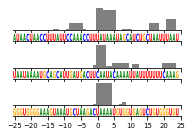

In [37]:
example_outputs = find_entropy_examples(top1_data, homologs_map, "utr3", gene = "YNL255C", rs = 12345)
plot_entropy_examples(*example_outputs)


Sampling using random state 575485529
S.cerevisiae:	 XIII:507360:-	YMR120C	utr3	2079.666666666667	3.037304904007171
S.pombe     :	 I:3685697:-	SPAC15A10.05c	utr3	9.5	1.9984084470540644
H.sapiens   :	 2:3580917:+	ENSG00000171863.15	terminal_exon	62824.5	1.3525461937014922


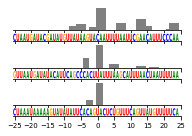

In [15]:
example_outputs = find_entropy_examples(top1_data, homologs_map, "utr3", rs = 575485529)
plot_entropy_examples(*example_outputs)


Sampling using random state 84549916
S.cerevisiae:	 VII:145440:+	YGL191W	utr3	214.0	2.889099023272492
S.pombe     :	 II:2447715:+	SPBC12C2.12c	utr3	22.5	2.2054108399819747
H.sapiens   :	 8:10765159:-	ENSG00000254093.9	terminal_exon	2609.5	0.9806633275578652


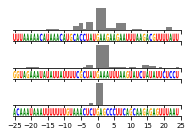

In [13]:
example_outputs = find_entropy_examples(top1_data, homologs_map, "utr3", rs = 84549916)
plot_entropy_examples(*example_outputs)


Sampling using random state 333671024
S.cerevisiae:	 XIV:677114:-	YNR029C	utr3	219.5	2.771703144884791
S.pombe     :	 II:312385:+	SPBC1773.13	utr3	11.5	1.9680801750771015
H.sapiens   :	 5:134605849:-	ENSG00000152700.14	terminal_exon	2457.0	1.090856645916751


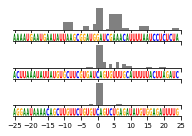

In [14]:
example_outputs = find_entropy_examples(top1_data, homologs_map, "utr3", rs = 333671024)
plot_entropy_examples(*example_outputs)


Sampling using random state 1430069742
S.cerevisiae:	 X:262675:-	YJL090C	utr3	98.0	2.811237587464904
S.pombe     :	 II:1586585:+	SPBC28F2.09	utr3	94.0	1.6477582938119506
H.sapiens   :	 22:42692121:-	ENSG00000128274.17	terminal_exon	990.5	1.4936979516280675


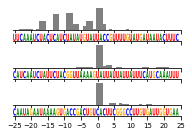

In [15]:
example_outputs = find_entropy_examples(top1_data, homologs_map, "utr3", rs = 1430069742)
plot_entropy_examples(example_outputs)


Sampling using random state 3716437642
S.cerevisiae:	 XV:197111:+	YOL071W	utr3	46.5	3.1182944505339605
S.pombe     :	 II:902701:+	SPBC216.03	utr3	27.5	1.9556774666050067
H.sapiens   :	 1:2403974:-	ENSG00000157911.11	terminal_exon	1550.5	1.6575146088164647


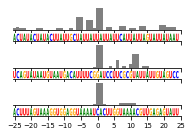

In [16]:
example_outputs = find_entropy_examples(top1_data, homologs_map, "utr3", rs = 3716437642)
plot_entropy_examples(*example_outputs)


### Summarizing entropy of top sites across species

#### All sites

(25603, 20)


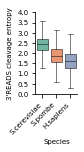

Wilcoxon rank sum test comparing the entropy between species-
S.cerevisiae vs S.pombe  : RanksumsResult(statistic=50.304921685031424, pvalue=0.0)
S.cerevisiae vs H.sapiens: RanksumsResult(statistic=87.08622945911227, pvalue=0.0)
S.pombe vs H.sapiens     : RanksumsResult(statistic=29.271806253632054, pvalue=2.3704906313029797e-188)

Summary data-
              count    median      mean       std       min       max
species                                                              
S.cerevisiae   5521  2.430281  2.394532  0.435537  0.000726  3.619400
S.pombe        3980  1.871125  1.850675  0.486245  0.000726  3.181590
H.sapiens     16102  1.610857  1.590565  0.490916  0.000726  3.320501


In [17]:
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

plot_data = top1_data.copy()
print(plot_data.shape)

sns.boxplot(data = plot_data, x = 'species', y = 'observed_entropy', 
            hue = 'species', palette = species_palette, dodge = False,
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black'},
            showfliers = False, 
            ax = ax)

ax.set_xlabel("Species")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right', va = 'top')

ax.set_ylabel("3'READS cleavage entropy")
ax.set_ylim(0,4)
ax.yaxis.set_major_locator(MultipleLocator(0.5))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend().remove()

plt.savefig(os.path.join(OUTDIR, 'species_entropy_comparison.golden_top-1.all.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Wilcoxon rank sum test comparing the entropy between species-")

print("S.cerevisiae vs S.pombe  :", st.ranksums(plot_data.loc[plot_data['species'] == 'S.cerevisiae', 'observed_entropy'],
                                                plot_data.loc[plot_data['species'] == 'S.pombe',      'observed_entropy']))

print("S.cerevisiae vs H.sapiens:", st.ranksums(plot_data.loc[plot_data['species'] == 'S.cerevisiae', 'observed_entropy'],
                                                plot_data.loc[plot_data['species'] == 'H.sapiens',    'observed_entropy']))

print("S.pombe vs H.sapiens     :", st.ranksums(plot_data.loc[plot_data['species'] == 'S.pombe',      'observed_entropy'],
                                                plot_data.loc[plot_data['species'] == 'H.sapiens',    'observed_entropy']))


print("\nSummary data-")
print(plot_data.groupby('species')['observed_entropy'].agg(['count','median','mean','std','min','max']).loc[species_order])


#### Sites in homologous genes

(9793, 20)


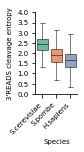

Wilcoxon rank sum test comparing the entropy between species-
S.cerevisiae vs S.pombe  : RanksumsResult(statistic=40.42140504146177, pvalue=0.0)
S.cerevisiae vs H.sapiens: RanksumsResult(statistic=56.9034888773738, pvalue=0.0)
S.pombe vs H.sapiens     : RanksumsResult(statistic=20.720182139344466, pvalue=2.2782201622169946e-95)

Summary data-
              count    median      mean       std       min       max
species                                                              
S.cerevisiae   3296  2.451186  2.414348  0.425746  0.385215  3.498864
S.pombe        2720  1.905254  1.876430  0.481510  0.000726  3.144088
H.sapiens      3777  1.640953  1.623847  0.480665  0.000726  3.320501


In [18]:
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

plot_data = top1_data.loc[top1_data['conserved_yeast_to_human'] == True].copy()
print(plot_data.shape)

sns.boxplot(data = plot_data, x = 'species', y = 'observed_entropy', 
            hue = 'species', palette = species_palette, dodge = False,
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black'},
            showfliers = False, 
            ax = ax)

ax.set_xlabel("Species")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right', va = 'top')

ax.set_ylabel("3'READS cleavage entropy")
ax.set_ylim(0,4)
ax.yaxis.set_major_locator(MultipleLocator(0.5))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend().remove()

plt.savefig(os.path.join(OUTDIR, 'species_entropy_comparison.golden_top-1.homologous.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Wilcoxon rank sum test comparing the entropy between species-")

print("S.cerevisiae vs S.pombe  :", st.ranksums(plot_data.loc[plot_data['species'] == 'S.cerevisiae', 'observed_entropy'],
                                                plot_data.loc[plot_data['species'] == 'S.pombe',      'observed_entropy']))

print("S.cerevisiae vs H.sapiens:", st.ranksums(plot_data.loc[plot_data['species'] == 'S.cerevisiae', 'observed_entropy'],
                                                plot_data.loc[plot_data['species'] == 'H.sapiens',    'observed_entropy']))

print("S.pombe vs H.sapiens     :", st.ranksums(plot_data.loc[plot_data['species'] == 'S.pombe',      'observed_entropy'],
                                                plot_data.loc[plot_data['species'] == 'H.sapiens',    'observed_entropy']))


print("\nSummary data-")
print(plot_data.groupby('species')['observed_entropy'].agg(['count','median','mean','std','min','max']).loc[species_order])


#### Sites in non-homologous genes

(15810, 20)


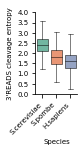

Wilcoxon rank sum test comparing the entropy between species-
S.cerevisiae vs S.pombe  : RanksumsResult(statistic=30.379752238922173, pvalue=1.0170105128275172e-202)
S.cerevisiae vs H.sapiens: RanksumsResult(statistic=57.79968292782155, pvalue=0.0)
S.pombe vs H.sapiens     : RanksumsResult(statistic=14.13176428789395, pvalue=2.4200439091707024e-45)

Summary data-
              count    median      mean       std       min       max
species                                                              
S.cerevisiae   2225  2.401618  2.365178  0.448138  0.000726  3.619400
S.pombe        1260  1.818812  1.795077  0.491928  0.000726  3.181590
H.sapiens     12325  1.602384  1.580366  0.493586  0.000726  3.241501


In [19]:
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

plot_data = top1_data.loc[top1_data['conserved_yeast_to_human'] == False].copy()
print(plot_data.shape)

sns.boxplot(data = plot_data, x = 'species', y = 'observed_entropy', 
            hue = 'species', palette = species_palette, dodge = False,
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black'},
            showfliers = False, 
            ax = ax)

ax.set_xlabel("Species")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right', va = 'top')

ax.set_ylabel("3'READS cleavage entropy")
ax.set_ylim(0,4)
ax.yaxis.set_major_locator(MultipleLocator(0.5))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend().remove()

plt.savefig(os.path.join(OUTDIR, 'species_entropy_comparison.golden_top-1.nonhomologous.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Wilcoxon rank sum test comparing the entropy between species-")

print("S.cerevisiae vs S.pombe  :", st.ranksums(plot_data.loc[plot_data['species'] == 'S.cerevisiae', 'observed_entropy'],
                                                plot_data.loc[plot_data['species'] == 'S.pombe',      'observed_entropy']))

print("S.cerevisiae vs H.sapiens:", st.ranksums(plot_data.loc[plot_data['species'] == 'S.cerevisiae', 'observed_entropy'],
                                                plot_data.loc[plot_data['species'] == 'H.sapiens',    'observed_entropy']))

print("S.pombe vs H.sapiens     :", st.ranksums(plot_data.loc[plot_data['species'] == 'S.pombe',      'observed_entropy'],
                                                plot_data.loc[plot_data['species'] == 'H.sapiens',    'observed_entropy']))


print("\nSummary data-")
print(plot_data.groupby('species')['observed_entropy'].agg(['count','median','mean','std','min','max']).loc[species_order])
